# Machine Learning Applied to Forecasting: Daily Electricity Production in Spain 2014-2018

The main goal of this lab is to test whether a general and simple approach based on Machine Learning models, can yield good enough results in a complex forecasting problem.

Our objective is to test this methodology to perform 30-ahead daily forecast in electricity demand (Spanish market). It is a very complex time series given that the country is not in a stationary economic cycle (recovering from a economic recession) and industrial production is shifting towards tourism and a flourishing but yet quite small, industrial equipment and machine exportation sector. Despite this positive circumstances, both GDP increase and tourism gronwth rate have stopped going up.

This comes with changes in electricity consumption patterns that are also affected by energy efficiency improvements and changes in household consumption behavior.

In addition, some very deep regulation changes where carried out in the last few years (from 2013), that further impact in electricity market, but this impact is more notorious in price time series. Nonetheless, some changes in regulation have triggered a steady switch from regulated tariff to free-market tariff, where a smarter daily consumption profile is encouraged.

The methodology explained is aimed to be an experiment to demonstrate that even with a very simple, easy to implement approach, (but advanced in Machine Learning expertise) we can success in an advanced forecasting problem (long term daily forecasting, only two years of training data and a complex time series). The main profit to be achieved is to no longer rely on methods that require deep time series analysis and heavy statistical assumptions on data, such as ARIMA.

EDA Objectives:
* Is target variable normal with constant volatility
* Is there a seasonal pattern
* Is there a trend pattern

Model building objectives:
* Train a Machine Learning model being able to forecast (predict on future data) 30 periods ahead
* Feature Engineering process is automatic and no assumptions on data statistical properties is required 
* Assessment will be carried out computing MAPE (Mean Absolute Percent Error) for each forecating horizong on a holdout dataset

$$ MAPE =\frac{1}{N} \sum_{i=1}^{N}\frac{|y-\hat{y}|}{y}$$


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from  scipy.stats import skew, kurtosis, shapiro
import mlflow
import dagshub
import os

### Import data

Data is Spanish daily electricity market demand in MWh

In [2]:
path = "Datasets/spain_energy_market.csv"
data = pd.read_csv(path, sep=",", parse_dates=["datetime"])
data = data[data["name"]=="Demanda programada PBF total"]#.set_index("datetime")
data["date"] = data["datetime"].dt.date
data.set_index("date", inplace=True)
data = data[["value"]]
data = data.asfreq("D")
data = data.rename(columns={"value": "energy"})
data.info()          

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2014-01-01 to 2018-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  1825 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [3]:
data[:5]

,energy
date,
2014-01-01,620107.7
2014-01-02,659865.2
2014-01-03,632536.8
2014-01-04,610251.7
2014-01-05,572534.1


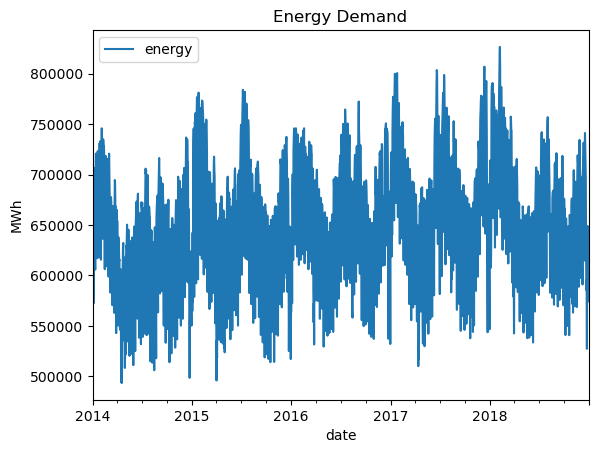

In [4]:
data.plot(title="Energy Demand")
plt.ylabel("MWh")
plt.show()

In [5]:
len(pd.date_range(start="2014-01-01", end="2018-12-31"))

1826

No missing values, and 4 years of data to enjoy :)

Let's compute some date features and start the fun part

C:\Users\user\AppData\Local\Temp\ipykernel_9564\880154106.py:6: FutureWarning: The provided callable <function mean at 0x0000019D09B3DD00> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
C:\Users\user\AppData\Local\Temp\ipykernel_9564\880154106.py:6: FutureWarning: The provided callable <function std at 0x0000019D09B3DE40> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
C:\Users\user\AppData\Local\Temp\ipykernel_9564\880154106.py:7: FutureWarning: The provided callable <function mean at 0x0000019D09B3DD00> is currently using Rolling.mean. In a future version of pandas, the provided callable will b

<Figure size 2000x1600 with 0 Axes>

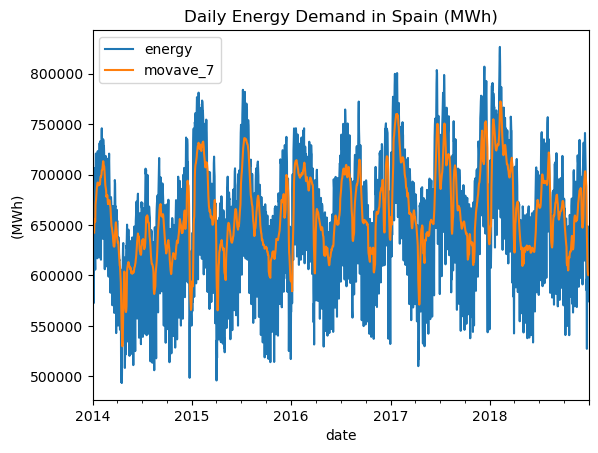

In [6]:
data["year"] = data.index.year
data["qtr"] = data.index.quarter
data["mon"] = data.index.month
data["day"] = data.index.weekday
data["ix"] = range(0,len(data))
data[["movave_7", "movstd_7"]] = data.energy.rolling(7).agg([np.mean, np.std])
data[["movave_30", "movstd_30"]] = data.energy.rolling(30).agg([np.mean, np.std])
data[["movave_90", "movstd_90"]] = data.energy.rolling(90).agg([np.mean, np.std])
data[["movave_365", "movstd_365"]] = data.energy.rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
data[["energy", "movave_7"]].plot(title="Daily Energy Demand in Spain (MWh)")
plt.ylabel("(MWh)")
plt.show()

## EDA: Exploratory Data Analysis
* Target Analysis
* Seasonality and Trend

The goal is to graphically characterize time series data, withouth relying on any (almost) any statistical method like decomposing.

## Target Analyisis: Normality

In [7]:
mean = np.mean(data.energy.values)
std = np.std(data.energy.values)
skew = skew(data.energy.values)
ex_kurt = kurtosis(data.energy)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: -0.2555279252628293 
Kurtosis: 2.6052606972453667


* Negative Skewness: Data distribution is not completelly simetric and has a left tail
* Kurtosis below 3: It means that tails are slightly thinner than in a Normal distribution. It is said that the distribution is platykurtic and the chance of finding extre values is lower than in a normal distribution.

In [8]:
def shapiro_test(data, alpha=0.05):
    stat, pval = shapiro(data)
    print("H0: Data was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))
        
shapiro_test(data.energy, alpha=0.05)

H0: Data was drawn from a Normal Ditribution
pval 2.5468191851953216e-10 is lower than significance level: 0.05, therefore null hypothesis is rejected


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\user\AppData\Local\Temp\ipykernel_9564\16411889.py:5: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
C:\Users\user\AppData\Local\Temp\ipykernel_9564\16411889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.energy)


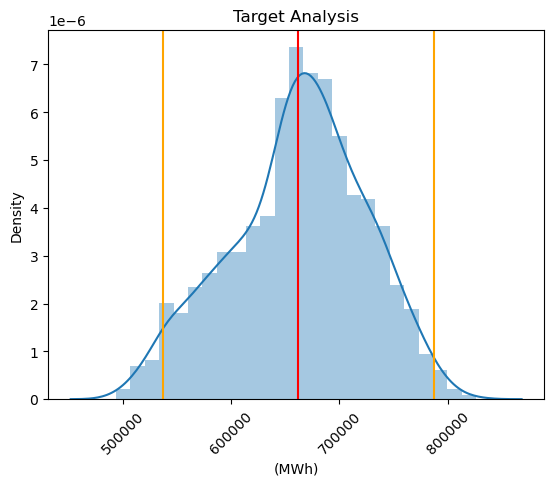

In [9]:
sns.distplot(data.energy)
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

Broadly speaking, data does not look like a normal distribution, because it has a small left tail and the chance of observing extreme values is smaller, comparing to normally distributed data

### Volatility Analysis

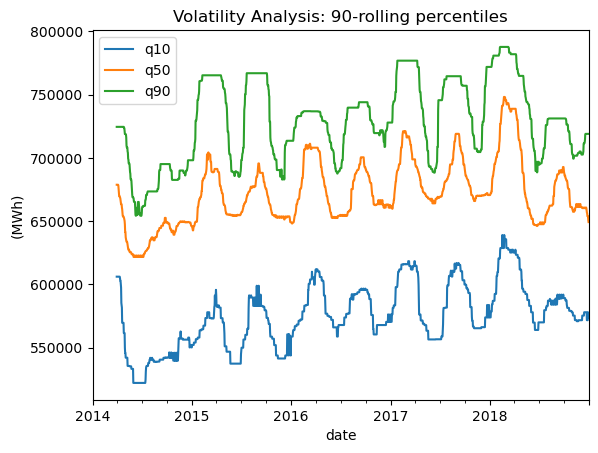

In [10]:
# Insert the rolling quantiles to the monthly returns
data_rolling = data.energy.rolling(window=90)
data['q10'] = data_rolling.quantile(0.1).to_frame("q10")
data['q50'] = data_rolling.quantile(0.5).to_frame("q50")
data['q90'] = data_rolling.quantile(0.9).to_frame("q90")

data[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(MWh)")
plt.show()

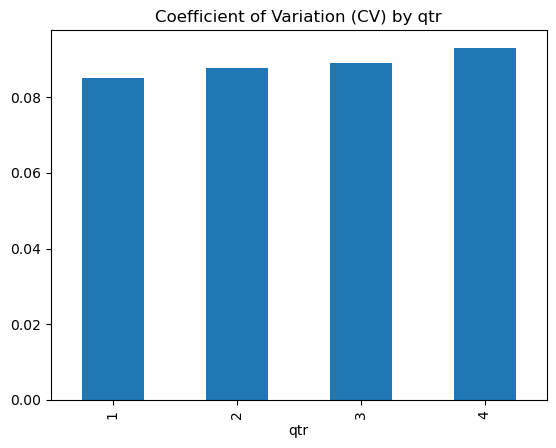

In [11]:
data.groupby("qtr")["energy"].std().divide(data.groupby("qtr")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by qtr")
plt.show()

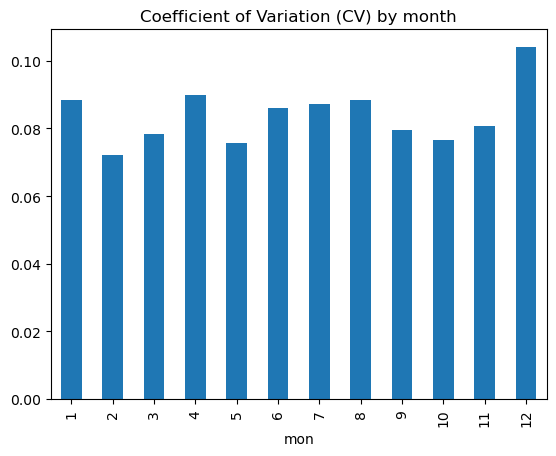

In [12]:
data.groupby("mon")["energy"].std().divide(data.groupby("mon")["energy"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

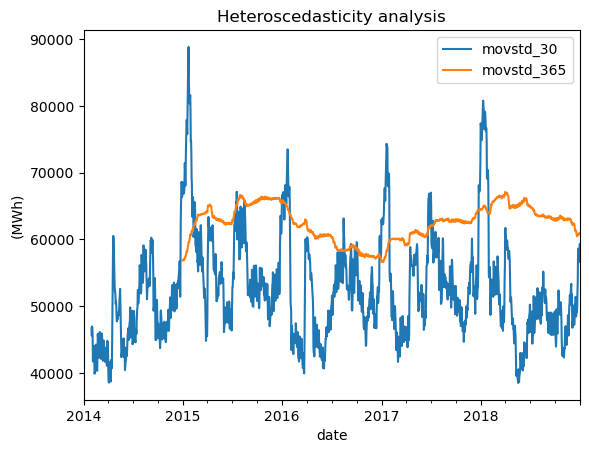

In [13]:
data[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

In the short term (quaterly and monthly) volatility is changeable, but in the long term (year window) it is quite stable, therefore, candidate predictors will have to deal with seasonal pattern in variance.

### Time Series Analysis: Seasonality and Trend

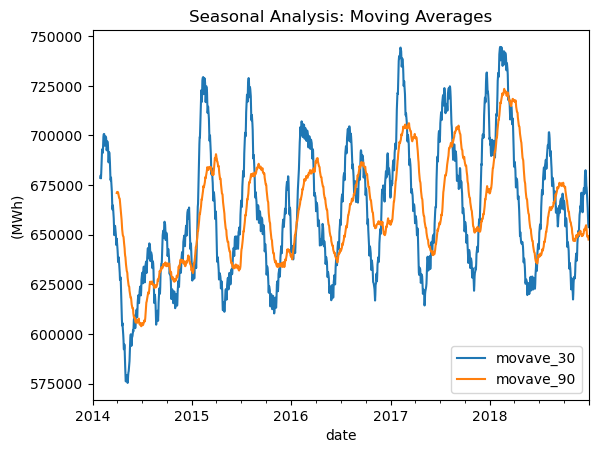

In [14]:
data[["movave_30", "movave_90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

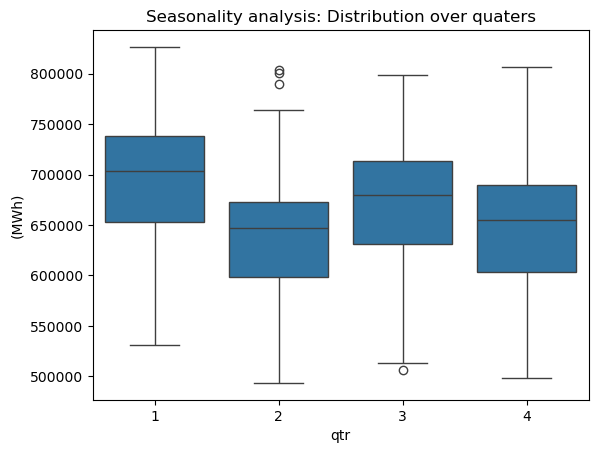

In [15]:
sns.boxplot(data=data, x="qtr", y="energy")
plt.title("Seasonality analysis: Distribution over quaters")
plt.ylabel("(MWh)")
plt.show()

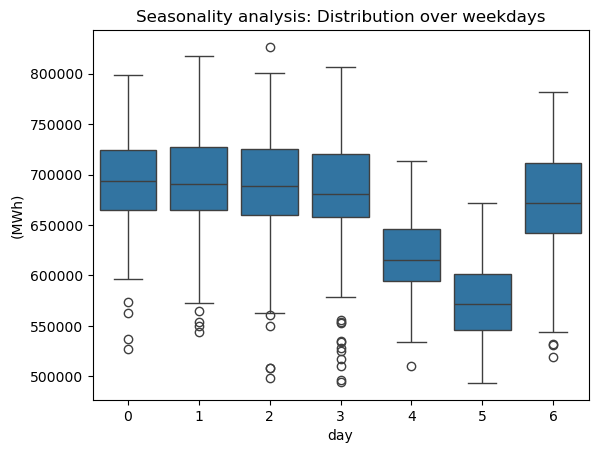

In [16]:
sns.boxplot(data=data, x="day", y="energy")
plt.title("Seasonality analysis: Distribution over weekdays")
plt.ylabel("(MWh)")
plt.show()

As expected, there are two clear seasonal pattern in quaterters and weekdays (0 is Monday)

In [17]:
data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
data_mon["ix"] = range(0, len(data_mon))
data_mon[:5]

C:\Users\user\AppData\Local\Temp\ipykernel_9564\3895441439.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_mon = data.energy.resample("M").agg(sum).to_frame("energy")
C:\Users\user\AppData\Local\Temp\ipykernel_9564\3895441439.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DatetimeIndexResampler.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_mon = data.energy.resample("M").agg(sum).to_frame("energy")


,energy,ix
date,,
2014-01-31,21017412.7,0
2014-02-28,19336398.7,1
2014-03-31,20040978.6,2
2014-04-30,17633177.7,3
2014-05-31,18572681.6,4


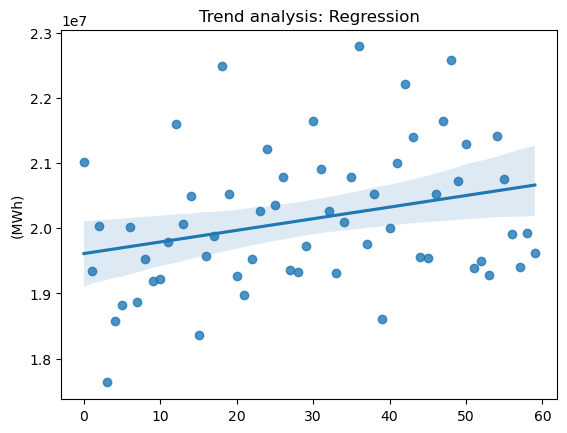

In [18]:
sns.regplot(data=data_mon,x="ix", y="energy")
plt.title("Trend analysis: Regression")
plt.ylabel("(MWh)")
plt.xlabel("")
plt.show()

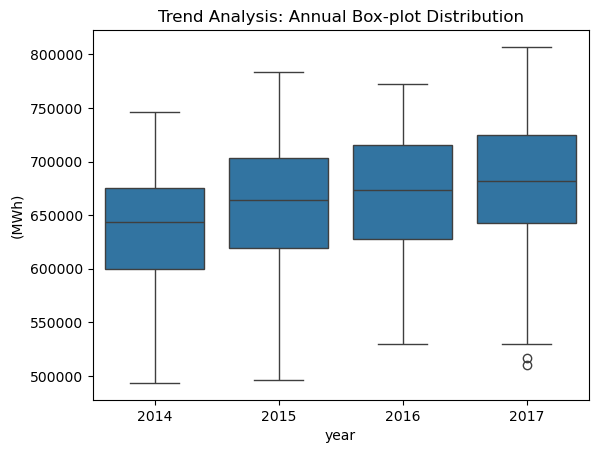

In [19]:
sns.boxplot(data=data["2014":"2017"], x="year", y="energy")
plt.title("Trend Analysis: Annual Box-plot Distribution")
plt.ylabel("(MWh)")
plt.show()

There is a positive linear (or sligthly damped) trend in energy demand, beacause of a steady economic grownth due to recession recovery.

## Feature Engineering

The challenge now is to create some features in a very automated way that can deal with seasonality, trend and changes in  volatility. The most basic strategy is to use lagged features and rolling window stats, but consider other advanced techniques for further research:
* Momentum and Mean reversion, like RSI in financial markets (https://en.wikipedia.org/wiki/Relative_strength_index)
* Sequence minning

Data is standardized in order to allow application of models that are sensitive to scale, like neural networks or svm. Remember that distribution shape is maintained, it only changes first and second momentum (mean and standard deviation)

C:\Users\user\AppData\Local\Temp\ipykernel_9564\1426062513.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["target"])


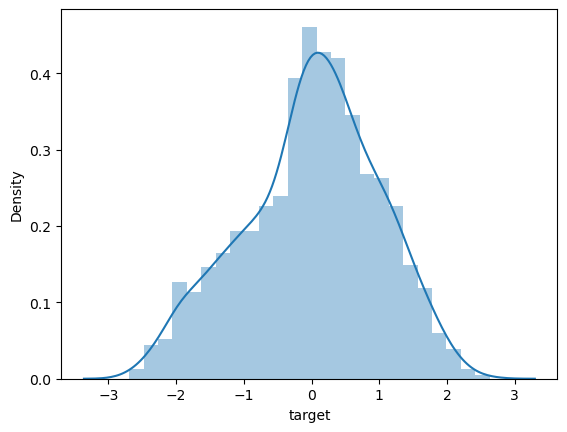

In [20]:
data["target"] = data.energy.add(-mean).div(std)
sns.distplot(data["target"])
plt.show()

In [21]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    data["target_t" + str(t)] = data.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    data["feat_ar" + str(t)] = data.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(data.mon,
                              prefix="mon",
                              drop_first=True)
months.index = data.index
data = pd.concat([data, months], axis=1)

days = pd.get_dummies(data.day,
                              prefix="day",
                              drop_first=True)
days.index = data.index
data = pd.concat([data, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

C:\Users\user\AppData\Local\Temp\ipykernel_9564\3865622915.py:19: FutureWarning: The provided callable <function mean at 0x0000019D09B3DD00> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\user\AppData\Local\Temp\ipykernel_9564\3865622915.py:19: FutureWarning: The provided callable <function std at 0x0000019D09B3DE40> is currently using Rolling.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = data.energy.rolling(t).agg([np.mean, np.std, np.max, np.min])
C:\Users\user\AppData\Local\Temp\ipykernel_9564\386

In [22]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

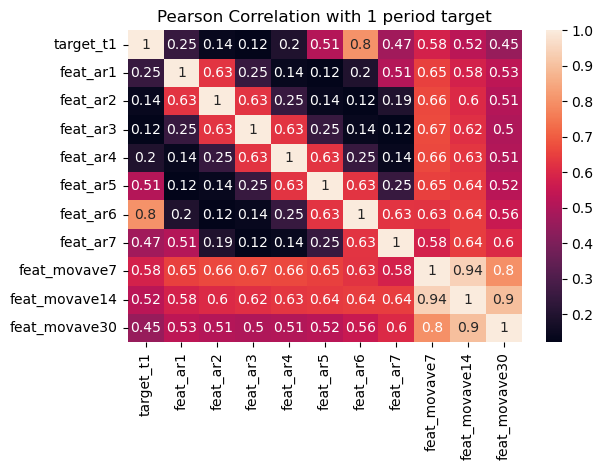

In [23]:
# Calculate correlation matrix
corr = data[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

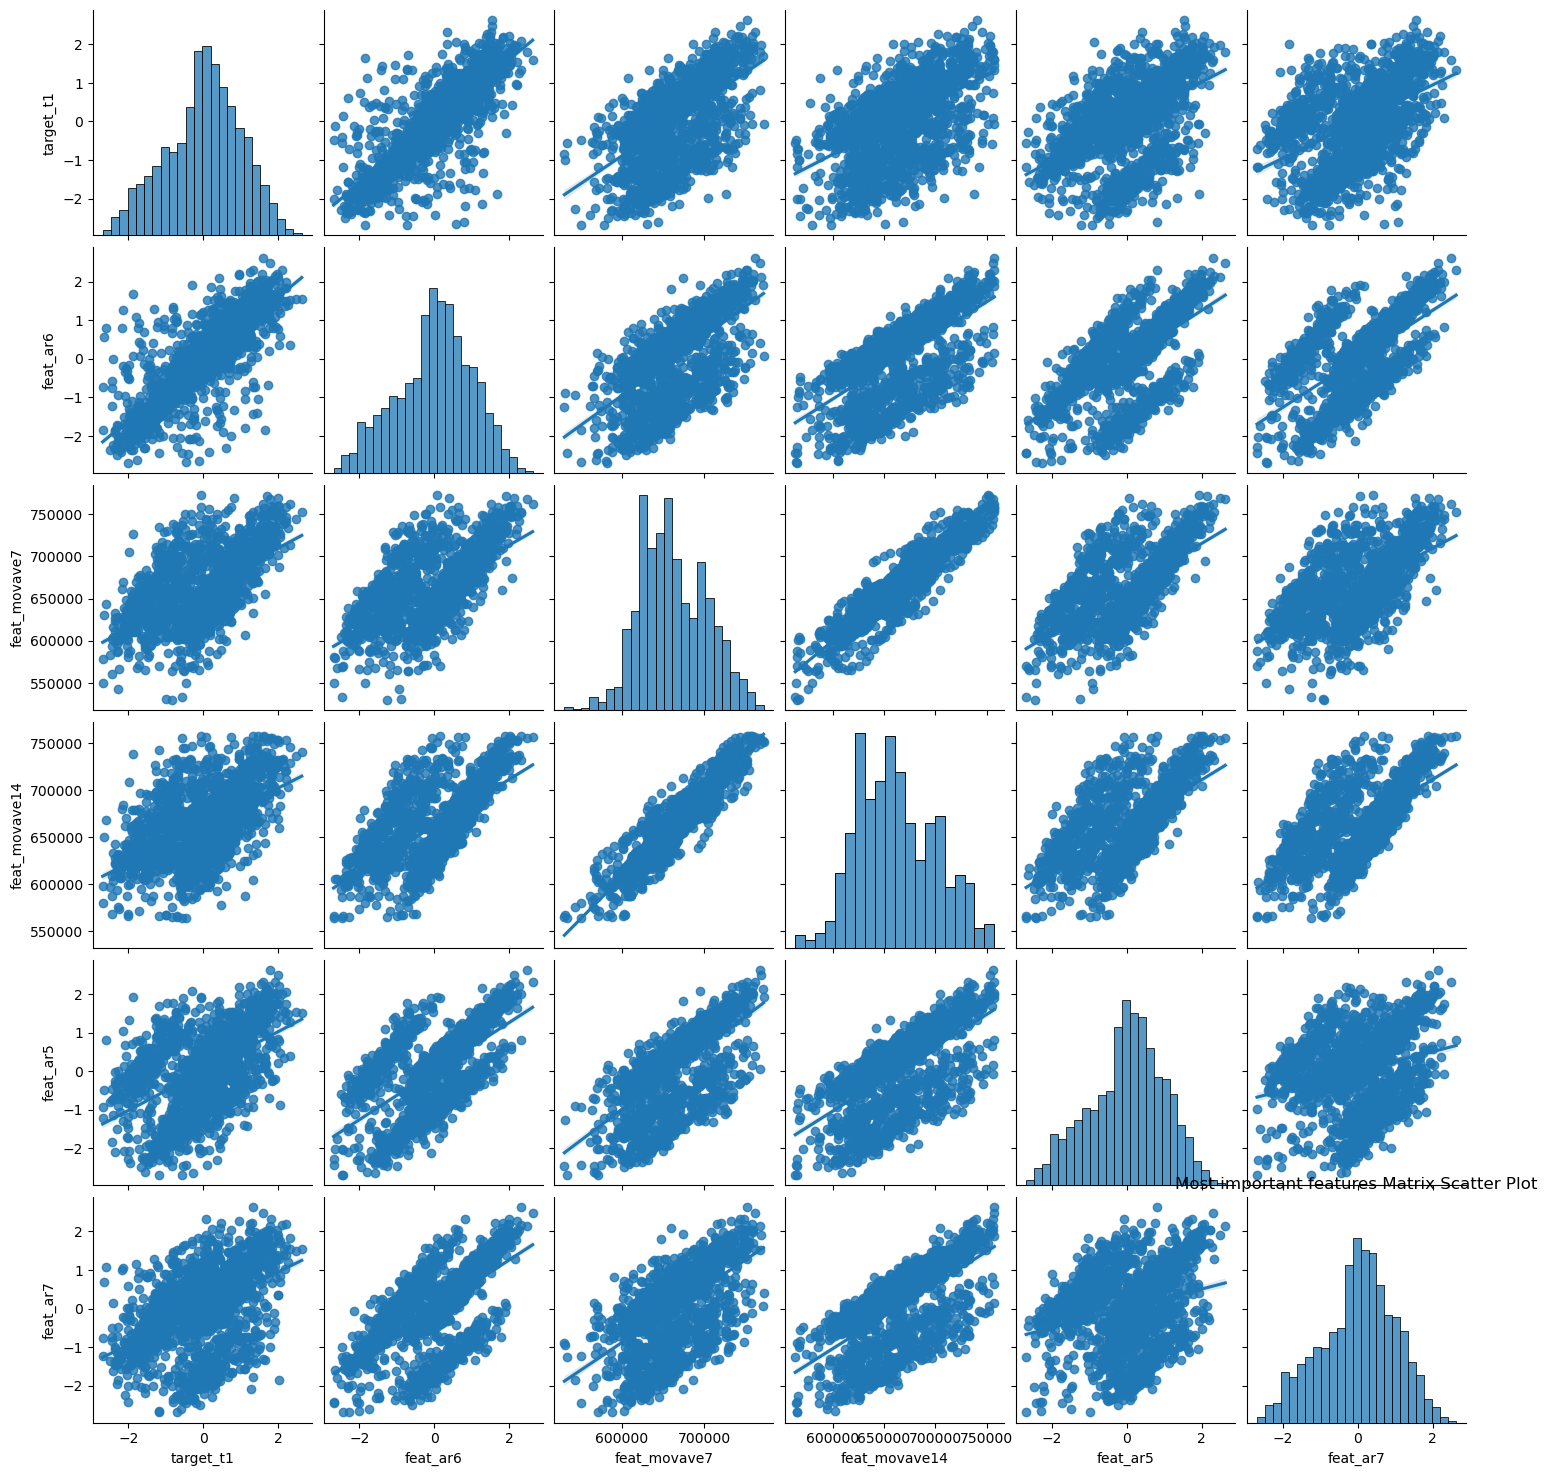

In [24]:
sns.pairplot(data=data[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

There are some features that are quite strongly linearly correlated with target, like AR_6 and MOVAVE_7, let's build some models and check this assumption

## Model Building

In this step, two candidates models are build using an nice feature in Scikit-Learn such us MultiOutput Regression, it provides a framework to automatically and easily fit models to predict several target variables.
(https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html)

First a baseline model (linear regression) will be fit and compared to a more advanced model, like Random Forest. 
A linear model does not need hyperparamenter tunning, and there is some correlation in data, so it is a strongh foundation, but there are several caveats:
* Target variable is not perfectly normally distributed with constant variance
* There are a lot of multicollinearity among predictors
* Observations are not independent

On the other hand an advanced model, like Random Forest, needs to perform hyperparamenter tunning, tipically it is solved by using GridSearch and Cross Validation, but time series data is not suitable to be used in CV, because **data is shuffled in order to build k-folds**. On the other hand, Scikit-Learng provide us with a nice solution: TimeSeries Splits, that respect time structure of date and iterativelly allow us to perform GridSearch


In [25]:
data_feateng = data[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  1765


### Split Data
Data points in 2018 are used as a holdout data to perform a honest assessment of model performance and carry out some residual analysis (6 months)

Total number of observations:  1765
Train: (1431, 59)(1431, 30), 
Test: (334, 59)(334, 30)


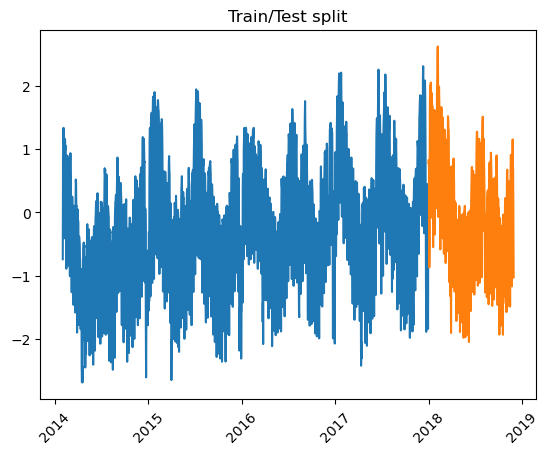

In [26]:

X_train = data_feateng.loc["2014":"2017"][features]
y_train = data_feateng.loc["2014":"2017"][targets]

X_test = data_feateng.loc["2018"][features]
y_test = data_feateng.loc["2018"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

### Baseline Model: Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.3329800070949789
Test RMSE: 0.2770515988418529


### Train a Random Forest with Time Series Split to tune Hyperparameters

In this example, TimeSeriesSplit framework is shown, on each fold, train data is closer to the beginning of forecasting period

TRAIN: 360 TEST: 357


C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


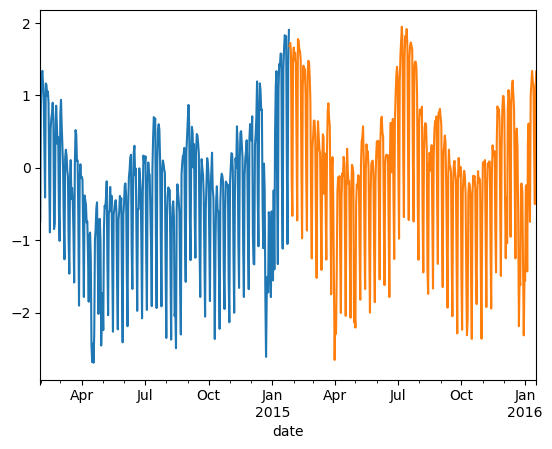

TRAIN: 717 TEST: 357


C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


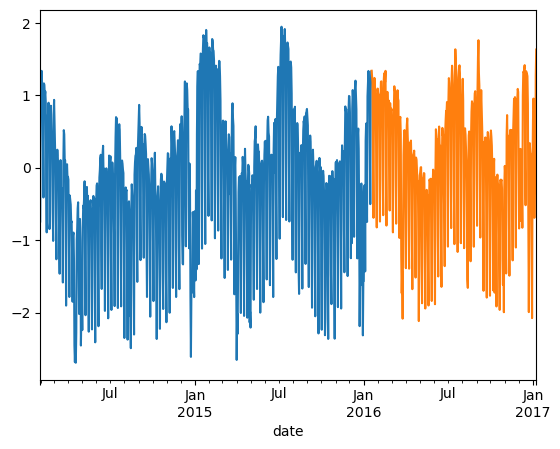

TRAIN: 730 TEST: 357


C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][train_index].plot()
C:\Users\user\AppData\Local\Temp\ipykernel_9564\2920908963.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["target_t1"][val_index].plot()


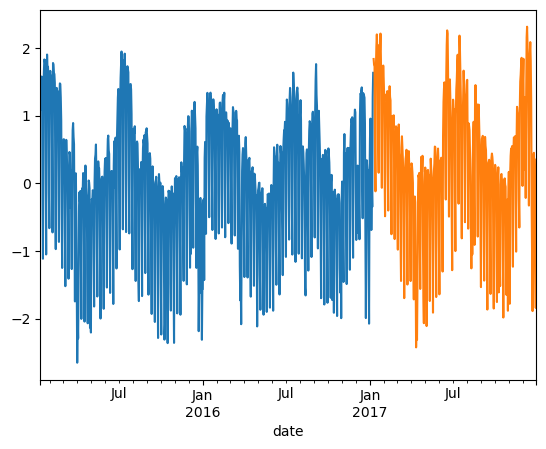

In [28]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()
   

In [29]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 10}
Best-Fold Train RMSE:  0.030324468201182342
Best-Fold Val RMSE:  0.21215787764817834


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 20}
Best-Fold Train RMSE:  0.022225084451683037
Best-Fold Val RMSE:  0.18590042166791146


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 16, 'max_depth': 10}
Best-Fold Train RMSE:  0.028482009744979626
Best-Fold Val RMSE:  0.217026072216893




In [30]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017", "target_t1"])


Using Random Forest provides an important improvement compared to Linear Regression. A word of caution, as RF are built bootstrapping data, so some time structure may be lost.

https://en.wikipedia.org/wiki/Bootstrap_aggregating

### Feature Importance

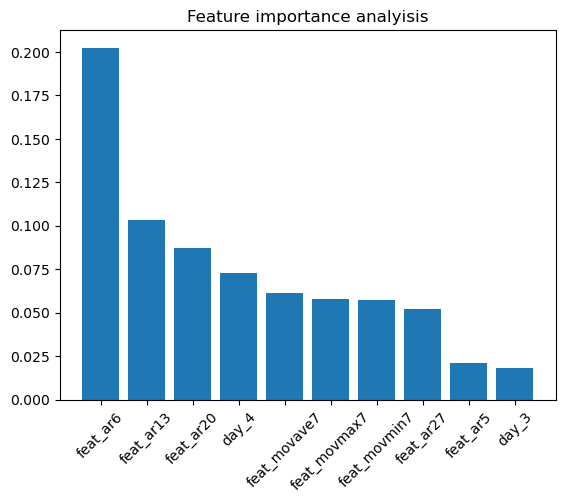

In [31]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

Results are not de same as the ones yielded by correlation analysis, showing that complex relationships and interactions may impact model performance. This is a very important point to take into consideration when working with models like ARIMA:

## Model Assessment:

### Performance Metrics: MAPE (Mean Absolute Percent Error)

Even though RMSE is a very common performance metric, MAPE is very suitable to use, and much easer to understand and communicate. Let's use one period ahead model to compute MAPE in test period

In [32]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [33]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  0.08747070456988605


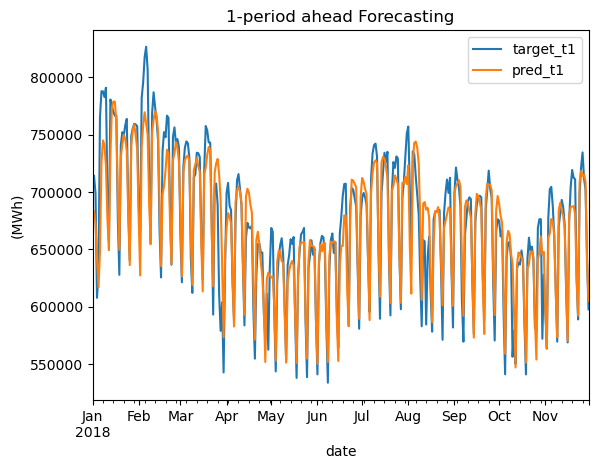

In [34]:
test_df[["target_t1", "pred_t1"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(MWh)")
plt.legend()
plt.show()

MAPE is slightly over 10%, considering that electricity demand is highly dependend on weather, and February was exceptionally cold, it is an astonishing result. However, can it be improved? Keep reading :)

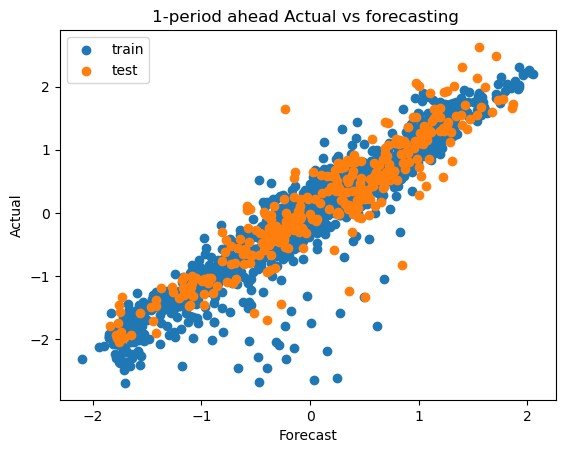

In [35]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

Plotting actual vs forecasted provides a glance on how good model can fit train data and generalize to test data

### Residual Analysis

In order to perform a comprehensive exercise, a residual analysis is carried out, in order to verify:

* Is there some skewness in forecasting (tendendy to over or under forecast)?
    * Verify that residuals are normally distributed
* Does outliers impact on performance? Is there any information remaining on residuals?
    * Residual over time
    * Plot Residual vs Actual

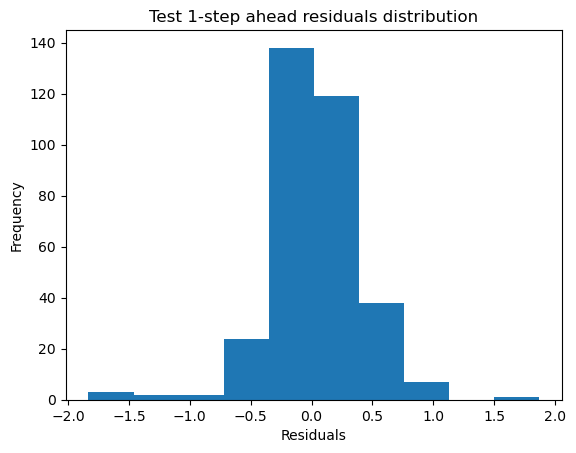

In [36]:
test_resid_1step.plot.hist(bins=10, title="Test 1-step ahead residuals distribution")
plt.xlabel("Residuals")
plt.show()

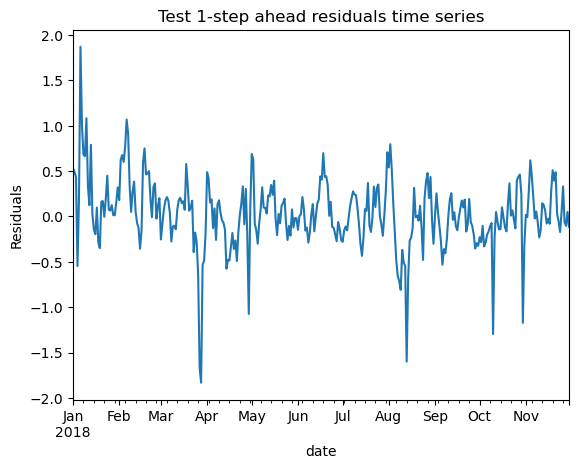

In [37]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.ylabel("Residuals")
plt.show()

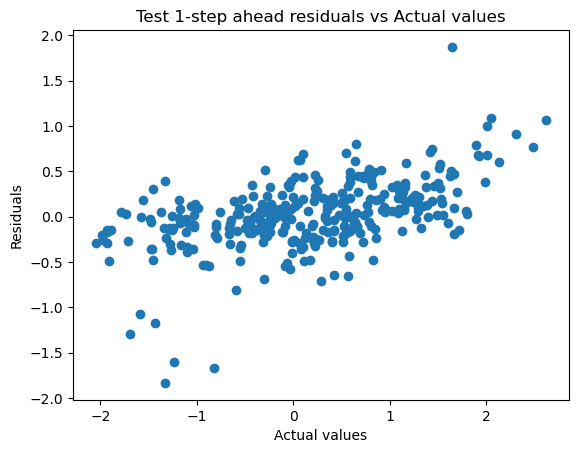

In [38]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.ylabel("Residuals")
plt.xlabel("Actual values")
plt.show()

## Forecasting

### Muti-period ahead model building

Once we know the best hiperparam set, a new instance of the RF model can be fit on the most recent (and relevant) data. Usually, it is considered that at least 2 years are needed in order to produce a long term daily forecast. Let's re-train a family of RF models using MultiOutput Regressor feature.

In [39]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2016":"2017"], y_train.loc["2016":"2017"])

In [40]:
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

### Performance Metrics: MAPE (Mean Absolute Percent Error)

Lastly, it is necesary to test forecasting accuracy in several periods, and assess whether it is stable.

In [41]:
periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)

print("MAPE test: ", test_MAPE)

MAPE test:  [2.67, 3.6999999999999997, 3.7900000000000005, 4.2299999999999995]


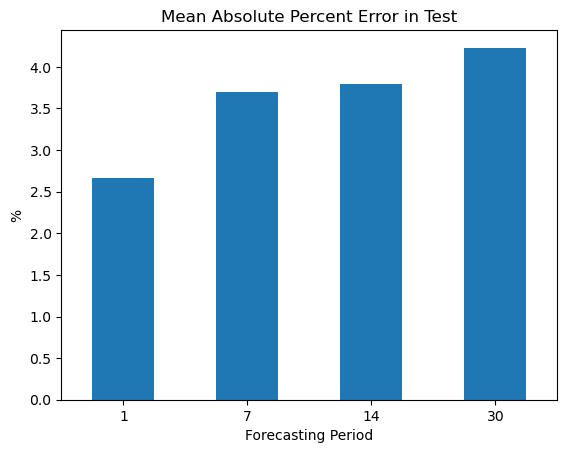

In [42]:
mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

Not surprisingly, forecasting accuacy on 1 period **INCREASES**, more data, not always is better. Moreover, MAPE increases with forecasting horizon, but it seems quite stable.

### Actual vs Forecasted
As previously stated, a quick way to assess model fit is to plot actual vs forecasted and take a glance at data scattering

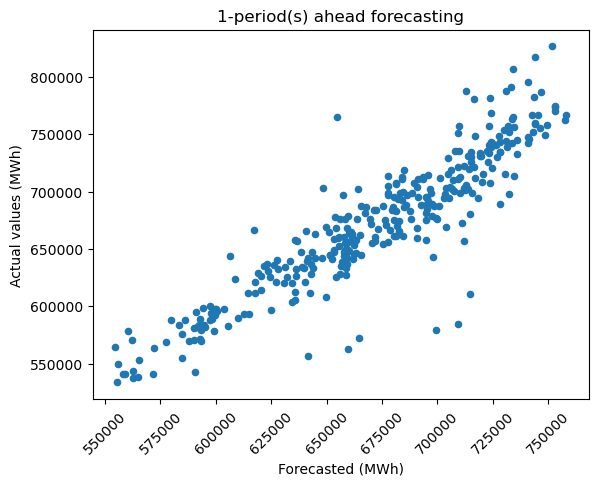

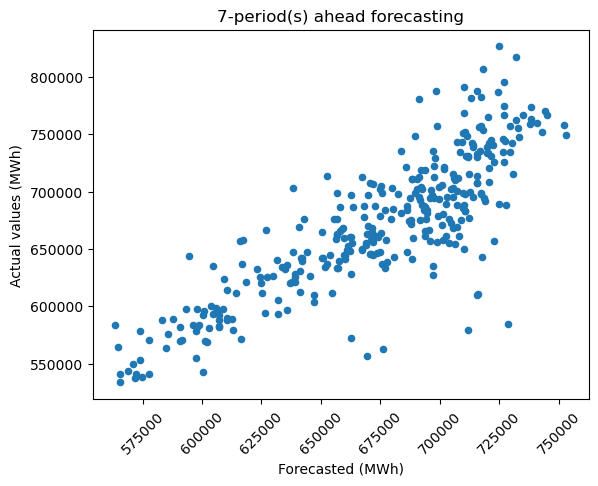

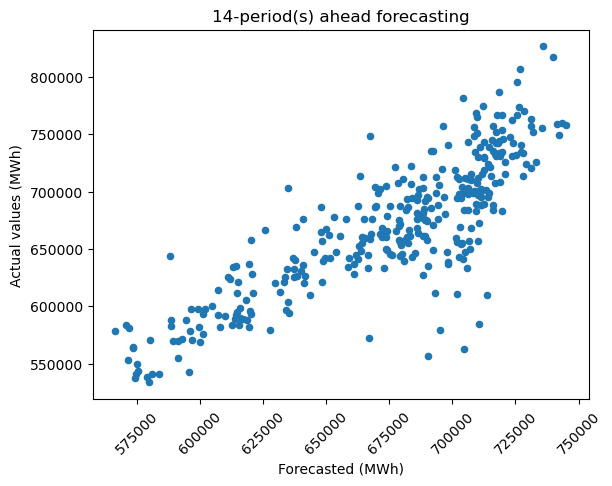

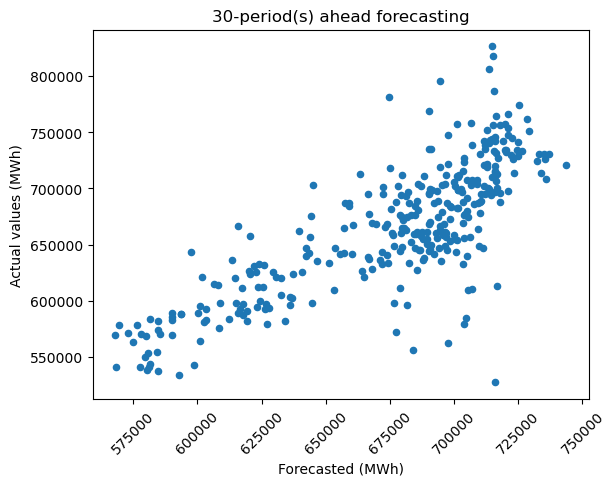

In [43]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("{}-period(s) ahead forecasting".format(t))
    plt.xlabel("Forecasted (MWh)")
    plt.ylabel("Actual values (MWh)")
    plt.xticks(rotation=45)
    plt.show()

It can be seen that, as forecasting period is longer, scattering is greater, specially for extreme values

### Forecasting 30-days ahead

In [44]:
test_df.index = test_df.index.date

In [45]:
forecast_range = pd.date_range(start=np.max(test_df.index.values), periods=tau, freq="D")
len(forecast_range)

30

In [46]:
forecast = []
for t in range(0, tau):
    #print(-(t+1), (t))
    forecast = p_test[-(t+1):,(t)]*std+mean

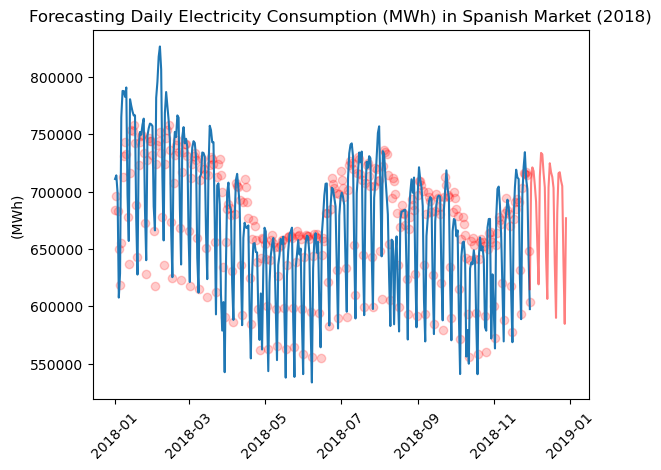

In [47]:
test_df["target_t1"].plot()
plt.scatter(x=test_df.index, y=test_df["pred_t1"], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range, forecast, c="r", alpha=0.5, label="forecasting")
plt.ylabel("(MWh)")
plt.xticks(rotation=45)
plt.title("Forecasting Daily Electricity Consumption (MWh) in Spanish Market (2018)")
plt.show()

### MLOPs Below

In [48]:
os.environ["MLFLOW_TRACKING_USERNAME"] = "kratugautam99"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "cb01ebb9449cf8b90cd91babb1c4fedce0ed1ce1"
os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/kratugautam99/MLOps-Dagshub.mlflow"
dagshub.init(repo_owner='kratugautam99', repo_name='MLOps-Dagshub', mlflow=True)

Accessing as kratugautam99

Initialized MLflow to track repo "kratugautam99/MLOps-Dagshub"

Repository kratugautam99/MLOps-Dagshub initialized!

In [49]:
mlflow.set_experiment("Spain Energy Market Forecasting")
#mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_tracking_uri("https://dagshub.com/kratugautam99/MLOps-Dagshub.mlflow")
with mlflow.start_run(run_name="Spain Energy Market Forecasting Run"):
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", best_rfr_grid["n_estimators"])
    mlflow.log_param("max_depth", best_rfr_grid["max_depth"])
    mlflow.log_param("max_features", best_rfr_grid["max_features"])
    
    mlflow.log_metric("train_rmse", RMSE_train)
    mlflow.log_metric("test_rmse", RMSE_test)
    
    mlflow.sklearn.log_model(best_rfr, "Random Forest Regressor Model")

    mlflow.log_artifact("Datasets/spain_energy_market.csv")  

2025/06/26 04:07:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Spain Energy Market Forecasting Run at: https://dagshub.com/kratugautam99/MLOps-Dagshub.mlflow/#/experiments/0/runs/09bfe621bbf743d4a9b66d95de33d248
🧪 View experiment at: https://dagshub.com/kratugautam99/MLOps-Dagshub.mlflow/#/experiments/0


In [50]:
# 1) you already logged to "Random Forest Regressor Model"
mlflow.sklearn.log_model(best_rfr, artifact_path="Random Forest Regressor Model")

# 2) register pointing at that same name
run_id = "018c661e114f442d9ed725df775f34eb"
model_uri  = f"runs:/{run_id}/Random Forest Regressor Model"
model_name = "EleDemand(RF)" 
result = mlflow.register_model(model_uri, model_name)

2025/06/26 04:07:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'EleDemand(RF)' already exists. Creating a new version of this model...
2025/06/26 04:08:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: EleDemand(RF), version 2
Created version '2' of model 'EleDemand(RF)'.


In [51]:
# 3) load later with
#loaded = mlflow.pyfunc.load_model("models:/Random_Forest_Regressor/1") OR
loaded = mlflow.pyfunc.load_model(f"models:/{model_name}@student")

In [52]:
# 4) predict with
y_pred = loaded.predict(X_test)
y_pred[:5]

array([ 0.25354138,  0.34140853,  0.15650236, -0.32284414, -0.72572305])

In [53]:
# 5) copy the model version to a new stage
client = mlflow.tracking.MlflowClient()
copied = client.copy_model_version(
    f"models:/{model_name}@student",         
    "EleDemand[Final]"  
)

Registered model 'EleDemand[Final]' already exists. Creating a new version of this model...
Copied version '1' of model 'EleDemand(RF)' to version '2' of model 'EleDemand[Final]'.


I hope that this has been an interesting LAB, and that you have enjoyed the exercise. Let's point out futher topics:
* Use a MLP (maybe a Keras NN with several neurons in the output layer and a custom perfomance metric)
* Use advanced feature engineering and independent variables
* Implement calendar